# Faishon Search AI - RAG with LlamaIndex

### In this notebook we are working with Myntra Dataset to build a RAG model using LlamaIndex. This is BYOP assignment as part of Building effective search system project. Dataset: https://www.kaggle.com/datasets/djagatiya/myntra-fashion-product-dataset

**Retrieval Augmented Generation (RAG)**

LLMs are trained on vast datasets, but these will not include your specific data. Retrieval-Augmented Generation (RAG) addresses this by dynamically incorporating your data during the generation process. This is done not by altering the training data of LLMs, but by allowing the model to access and utilize your data in real-time to provide more tailored and contextually relevant responses.

In RAG, your data is loaded and and prepared for queries or “indexed”. User queries act on the index, which filters your data down to the most relevant context. This context and your query then go to the LLM along with a prompt, and the LLM provides a response.

Even if what you’re building is a chatbot or an agent, you’ll want to know RAG techniques for getting data into your application.

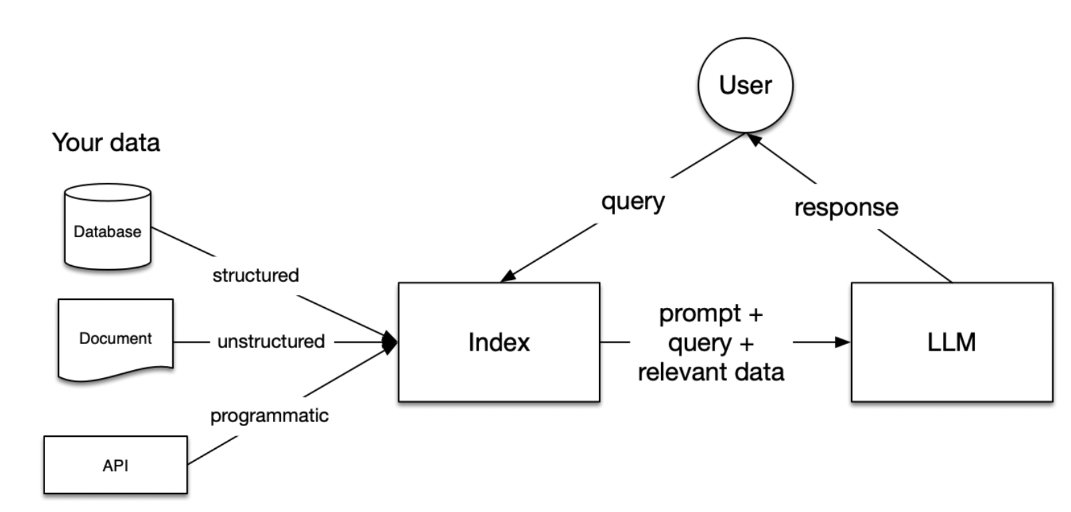

**Stages within RAG**

There are five key stages within RAG, which in turn will be a part of any larger application you build. These are:

**Loading:** this refers to getting your data from where it lives – whether it’s text files, PDFs, another website, a database, or an API – into your pipeline. LlamaHub provides hundreds of connectors to choose from.

**Indexing:** this means creating a data structure that allows for querying the data. For LLMs this nearly always means creating vector embeddings, numerical representations of the meaning of your data, as well as numerous other metadata strategies to make it easy to accurately find contextually relevant data.

**Storing:** Once your data is indexed, you will want to store your index, along with any other metadata, to avoid the need to re-index it.

**Querying:** for any given indexing strategy there are many ways you can utilize LLMs and LlamaIndex data structures to query, including sub-queries, multi-step queries and hybrid strategies.

## Build RAG system.

Now that we have understood the significance of RAG system, let's build a simple RAG pipeline.

In [5]:
!pip install llama-index

In [6]:
!pip install transformers accelerate sentence-transformers llama-index


In [7]:
# The nest_asyncio module enables the nesting of asynchronous functions within an already running async loop.
# This is necessary because Jupyter notebooks inherently operate in an asynchronous loop.
# By applying nest_asyncio, we can run additional async functions within this existing loop without conflicts.
import nest_asyncio

nest_asyncio.apply()

from llama_index.core.evaluation import generate_question_context_pairs
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core.evaluation import generate_question_context_pairs
from llama_index.core.evaluation import RetrieverEvaluator
from llama_index.llms.openai import OpenAI

import os
import pandas as pd
import openai

##### Set Your OpenAI API Key

In [8]:
import os, json, ast
from IPython.display import display, Image

In [9]:
with open("keys.txt", "r") as file:
 openai.api_key = file.read().strip()  # Removes extra spaces/newlines

#Check if the API key is loaded correctly
print(f"OpenAI API Key: {openai.api_key[:5]}*****")  # Masked for security

OpenAI API Key: sk-pr*****


#### Read Data

In [10]:
myntra_data = pd.read_csv("Fashiondata.csv", encoding="utf-8")
myntra_data.head(10)

,p_id,name,products,price,colour,brand,img,ratingCount,avg_rating,description,p_attributes
0,17048614,Khushal K Women Black Ethnic Motifs Printed Ku...,"Kurta, Palazzos, Dupatta",5099.0,Black,Khushal K,http://assets.myntassets.com/assets/images/170...,4522.0,4.418399,Black printed Kurta with Palazzos with dupatta...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
1,16524740,InWeave Women Orange Solid Kurta with Palazzos...,"Kurta, Palazzos, Floral Print Dupatta",5899.0,Orange,InWeave,http://assets.myntassets.com/assets/images/165...,1081.0,4.119334,Orange solid Kurta with Palazzos with dupatta<...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
2,16331376,Anubhutee Women Navy Blue Ethnic Motifs Embroi...,"Kurta, Trousers, Dupatta",4899.0,Navy Blue,Anubhutee,http://assets.myntassets.com/assets/images/163...,1752.0,4.161530,Navy blue embroidered Kurta with Trousers with...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
3,14709966,Nayo Women Red Floral Printed Kurta With Trous...,"Kurta, Trouser, Dupatta",3699.0,Red,Nayo,http://assets.myntassets.com/assets/images/147...,4113.0,4.088986,Red printed kurta with trouser and dupatta<br>...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
4,11056154,AHIKA Women Black & Green Printed Straight Kurta,Kurta,1350.0,Black,AHIKA,http://assets.myntassets.com/assets/images/110...,21274.0,3.978377,"Black and green printed straight kurta, has a ...","{'Body Shape ID': '424', 'Body or Garment Size..."
5,18704418,Soch Women Red Thread Work Georgette Anarkali ...,Anarkali Kurta,3498.0,Red,Soch,http://assets.myntassets.com/assets/images/187...,NaN,NaN,<ul> <li> Colour: red </li> <li> Solid woven d...,"{'Body Shape ID': '333,324,424', 'Body or Garm..."
6,14046594,Libas Women Navy Blue Pure Cotton Floral Print...,"Kurta, Palazzos, Dupatta",3599.0,Navy Blue,Libas,http://assets.myntassets.com/assets/images/140...,8695.0,4.435653,"Stately and versatile, this kurta set will be ...","{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
7,14951330,Ahalyaa Women Beige Floral Printed Regular Got...,"Kurta, Palazzos, Dupatta",6000.0,Beige,Ahalyaa,http://assets.myntassets.com/assets/images/149...,1741.0,3.545089,"When in doubt, rock this simple yet stylish ku...","{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
8,13791594,Anouk Women Yellow & White Printed Kurta with ...,"Kurta, Palazzos",1999.0,Yellow,Anouk,http://assets.myntassets.com/assets/images/137...,7012.0,4.245864,Yellow and white printed kurta with palazzos<b...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
9,17048604,Khushal K Women Green & Pink Printed Pure Cott...,"Kurta, Palazzos, Dupatta",5299.0,Green,Khushal K,http://assets.myntassets.com/assets/images/170...,1590.0,4.266038,Green &amp; pink printed kurta with palazzos &...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."


### Create MetaData

In [11]:
myntra_data['metadata'] = myntra_data.apply(
    lambda x: {
        'Product_id': x['p_id'],  # Unique identifier for the product
        'Name': x['name'],  # Product name
        'Product_type': x['products'],  # Type or category of the product
        'Price_INR': x['price'],  # Price of the product in Indian Rupees
        'Colour': x['colour'],  # Color of the product
        'Brand': x['brand'],  # Brand of the product
        'RatingCount': x['ratingCount'],  # Number of ratings received
        'Rating': x['avg_rating'],  # Average rating of the product
        'Description': x['description'],  # Description of the product
        'Product_attributes': x['p_attributes']  # Additional attributes of the product
    }, axis=1
)

In [12]:
myntra_data.head(10)

,p_id,name,products,price,colour,brand,img,ratingCount,avg_rating,description,p_attributes,metadata
0,17048614,Khushal K Women Black Ethnic Motifs Printed Ku...,"Kurta, Palazzos, Dupatta",5099.0,Black,Khushal K,http://assets.myntassets.com/assets/images/170...,4522.0,4.418399,Black printed Kurta with Palazzos with dupatta...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...","{'Product_id': 17048614, 'Name': 'Khushal K Wo..."
1,16524740,InWeave Women Orange Solid Kurta with Palazzos...,"Kurta, Palazzos, Floral Print Dupatta",5899.0,Orange,InWeave,http://assets.myntassets.com/assets/images/165...,1081.0,4.119334,Orange solid Kurta with Palazzos with dupatta<...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...","{'Product_id': 16524740, 'Name': 'InWeave Wome..."
2,16331376,Anubhutee Women Navy Blue Ethnic Motifs Embroi...,"Kurta, Trousers, Dupatta",4899.0,Navy Blue,Anubhutee,http://assets.myntassets.com/assets/images/163...,1752.0,4.161530,Navy blue embroidered Kurta with Trousers with...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...","{'Product_id': 16331376, 'Name': 'Anubhutee Wo..."
3,14709966,Nayo Women Red Floral Printed Kurta With Trous...,"Kurta, Trouser, Dupatta",3699.0,Red,Nayo,http://assets.myntassets.com/assets/images/147...,4113.0,4.088986,Red printed kurta with trouser and dupatta<br>...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...","{'Product_id': 14709966, 'Name': 'Nayo Women R..."
4,11056154,AHIKA Women Black & Green Printed Straight Kurta,Kurta,1350.0,Black,AHIKA,http://assets.myntassets.com/assets/images/110...,21274.0,3.978377,"Black and green printed straight kurta, has a ...","{'Body Shape ID': '424', 'Body or Garment Size...","{'Product_id': 11056154, 'Name': 'AHIKA Women ..."
5,18704418,Soch Women Red Thread Work Georgette Anarkali ...,Anarkali Kurta,3498.0,Red,Soch,http://assets.myntassets.com/assets/images/187...,NaN,NaN,<ul> <li> Colour: red </li> <li> Solid woven d...,"{'Body Shape ID': '333,324,424', 'Body or Garm...","{'Product_id': 18704418, 'Name': 'Soch Women R..."
6,14046594,Libas Women Navy Blue Pure Cotton Floral Print...,"Kurta, Palazzos, Dupatta",3599.0,Navy Blue,Libas,http://assets.myntassets.com/assets/images/140...,8695.0,4.435653,"Stately and versatile, this kurta set will be ...","{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...","{'Product_id': 14046594, 'Name': 'Libas Women ..."
7,14951330,Ahalyaa Women Beige Floral Printed Regular Got...,"Kurta, Palazzos, Dupatta",6000.0,Beige,Ahalyaa,http://assets.myntassets.com/assets/images/149...,1741.0,3.545089,"When in doubt, rock this simple yet stylish ku...","{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...","{'Product_id': 14951330, 'Name': 'Ahalyaa Wome..."
8,13791594,Anouk Women Yellow & White Printed Kurta with ...,"Kurta, Palazzos",1999.0,Yellow,Anouk,http://assets.myntassets.com/assets/images/137...,7012.0,4.245864,Yellow and white printed kurta with palazzos<b...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...","{'Product_id': 13791594, 'Name': 'Anouk Women ..."
9,17048604,Khushal K Women Green & Pink Printed Pure Cott...,"Kurta, Palazzos, Dupatta",5299.0,Green,Khushal K,http://assets.myntassets.com/assets/images/170...,1590.0,4.266038,Green &amp; pink printed kurta with palazzos &...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...","{'Product_id': 17048604, 'Name': 'Khushal K Wo..."


## Layer 1: Embedding Layer

#### Load Data and Build Index.

#### By default LlamaIndex uses text-embedding-ada-002

In [13]:
from llama_index.core import Document

In [14]:
# Convert each row into a Document
documents = []
for _, row in myntra_data.iterrows():
    metadata = row['metadata']  # Access the metadata dictionary
    documents.append(Document(metadata=metadata))
#documents

#### Node parser with chunking - chunk size=1000

In [15]:
# Define an LLM
llm = OpenAI(model="gpt-3.5-turbo")

# Build index with a chunk_size of 512
node_parser = SimpleNodeParser.from_defaults(chunk_size=1000)
nodes = node_parser.get_nodes_from_documents(documents)


In [16]:
node_parser

SentenceSplitter(include_metadata=True, include_prev_next_rel=True, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x2b24525d0>, id_func=<function default_id_func at 0x106883ce0>, chunk_size=1000, chunk_overlap=200, separator=' ', paragraph_separator='\n\n\n', secondary_chunking_regex='[^,.;。？！]+[,.;。？！]?|[,.;。？！]')

In [17]:
nodes[:3]

[TextNode(id_='25e2601a-24a2-4115-8d23-8e8f115d37f3', embedding=None, metadata={'Product_id': 17048614, 'Name': 'Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta', 'Product_type': 'Kurta, Palazzos, Dupatta', 'Price_INR': 5099.0, 'Colour': 'Black', 'Brand': 'Khushal K', 'RatingCount': 4522.0, 'Rating': 4.4183989385227775, 'Description': "Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  </b> <ul> <li> Ethnic motifs printed </li> <li> Anarkali shape </li> <li> Regular style </li> <li> Mandarin collar,  three-quarter regular sleeves </li> <li> Calf length with flared hem </li> <li> Viscose rayon machine weave fabric </li> </ul> <br> <b> Palazzos design:  </b> <ul> <li> Printed Palazzos </li> <li> Elasticated waistband </li> <li> Slip-on closure </li> </ul>Dupatta Length 2.43 meters Width:&nbsp;88 cm<br>The model (height 5'8) is wearing a size S100% Rayon<br>Machine wash", 'Product_attributes': "{'Add-Ons': 'NA', 'Body Shape ID': '443

In [76]:
pip show llama-index

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: llama-index
Version: 0.12.27
Summary: Interface between LLMs and your data
Home-page: 
Author: Jerry Liu
Author-email: jerry@llamaindex.ai
License: MIT
Location: /opt/anaconda3/lib/python3.11/site-packages
Requires: llama-index-agent-openai, llama-index-cli, llama-index-core, llama-index-embeddings-openai, llama-index-indices-managed-llama-cloud, llama-index-llms-openai, llama-index-multi-modal-llms-openai, llama-index-program-openai, llama-index-question-gen-openai, llama-index-readers-file, llama-index-readers-llama-parse, nltk
Required-by: 
Note: you may need to restart the kernel to use updated packages.


#### Caching using diskcache

In [85]:
import diskcache
CACHE_DIR = "./index_cache"
os.makedirs(CACHE_DIR, exist_ok=True)
cache = diskcache.Cache(CACHE_DIR)

def get_or_create_index(nodes):
    if "vector_index" in cache:
        print('found in cache')
        return cache["vector_index"]

    vector_index = VectorStoreIndex(nodes)
    cache["vector_index"] = vector_index
    return vector_index

In [86]:
vector_index = get_or_create_index(nodes)

found in cache


In [78]:
vector_index

In [79]:
len(nodes)

14214

## Layer2: Search Layer

#### Build a QueryEngine and start querying.

In [56]:
query_engine = vector_index.as_query_engine(similarity_top_k=3)

In [25]:
query_engine

In [80]:
response_vector = query_engine.query("I need a yellow Kurta under budget 2000")

In [81]:
#Test the query for first time Test1
import time
def timed_query(query_string: str):
    start_time = time.time()
    response = query_engine.query(query_string)
    end_time = time.time()
    print(f"Query execution time: {end_time - start_time:.4f} seconds")
    return response

In [82]:
#Test 1
query1 = "I need a yellow Kurta under budget 2000"
timed_query(query1)

Query execution time: 2.6105 seconds


Response(response='You can consider purchasing the "KETCH Women Yellow Printed Kurta" priced at 1049.0 INR.', source_nodes=[NodeWithScore(node=TextNode(id_='fc586652-6f4a-4c94-8671-6e577ca167f6', embedding=None, metadata={'Product_id': 11349574, 'Name': 'W Women Yellow & Golden Printed Straight Kurta', 'Product_type': 'Kurta', 'Price_INR': 1699.0, 'Colour': 'Yellow', 'Brand': 'W', 'RatingCount': 21.0, 'Rating': 4.333333333333333, 'Description': 'Yellow and Golden printed straight kurta, has a round neck, three-quarter sleeves, button closure, straight hem, and side slitsThe model (height 5\'8") is wearing a size SMaterial: 100% Viscose Rayon<br>Hand Wash', 'Product_attributes': "{'Body Shape ID': '424', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Colour Family': 'Bright', 'Design Styling': 'Regular', 'Fabric': 'Viscose Rayon', 'Fabric 2': 'NA', 'Fabric Purity': 'Synthetic', 'Hemline': 'Straight', 'Length': 'Knee Length', 'Main Trend': 'NA', 'Neck': 'Round Neck', 'Oc

In [90]:
#Test 2
query2 = "I need a yellow Kurta under budget 2000"
timed_query(query2)

Query execution time: 2.1337 seconds


Response(response='The yellow Kurta under budget 2000 is the "KETCH Women Yellow Printed Kurta" priced at 1049.0 INR.', source_nodes=[NodeWithScore(node=TextNode(id_='fc586652-6f4a-4c94-8671-6e577ca167f6', embedding=None, metadata={'Product_id': 11349574, 'Name': 'W Women Yellow & Golden Printed Straight Kurta', 'Product_type': 'Kurta', 'Price_INR': 1699.0, 'Colour': 'Yellow', 'Brand': 'W', 'RatingCount': 21.0, 'Rating': 4.333333333333333, 'Description': 'Yellow and Golden printed straight kurta, has a round neck, three-quarter sleeves, button closure, straight hem, and side slitsThe model (height 5\'8") is wearing a size SMaterial: 100% Viscose Rayon<br>Hand Wash', 'Product_attributes': "{'Body Shape ID': '424', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Colour Family': 'Bright', 'Design Styling': 'Regular', 'Fabric': 'Viscose Rayon', 'Fabric 2': 'NA', 'Fabric Purity': 'Synthetic', 'Hemline': 'Straight', 'Length': 'Knee Length', 'Main Trend': 'NA', 'Neck': 'Round 

In [ ]:
Test1: Query execution time: 2.6610 seconds
Test2: Query execution time: 2.1337 seconds

In [30]:
print(f"Total retrieved nodes: {len(response_vector.source_nodes)}\n")

Total retrieved nodes: 3



In [31]:
image_folder = "images/"

In [32]:
from typing import List

In [36]:
pip install --upgrade transformers sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [118]:
import os
from typing import List
from IPython.display import display, Image, HTML
from llama_index.core.schema import Node
import numpy as np
from sentence_transformers import SentenceTransformer
import torch

def display_images_from_nodes_withDescription_sentence_transformer(image_folder: str, query_string: str = None, metadata_key: str = "Product_id", image_extension: str = ".jpg"):
    """
    Displays images, metadata, and performs vector distance re-ranking using sentence-transformers,
    all in a single screen using HTML with compact key-value pairs.
    """
    response_vector = query_engine.query(query_string)
    source_nodes = response_vector.source_nodes
    
    embed_model = SentenceTransformer('all-MiniLM-L6-v2')

    if query_string:
        query_embedding = embed_model.encode(query_string, convert_to_tensor=True)
        node_embeddings = [embed_model.encode(node.get_content(), convert_to_tensor=True) for node in source_nodes]
        distances = [np.dot(query_embedding.cpu().numpy(), node_embedding.cpu().numpy()) for node_embedding in node_embeddings]
        sorted_nodes = [node for _, node in sorted(zip(distances, source_nodes), key=lambda x: x[0], reverse=True)]
    else:
        sorted_nodes = source_nodes

    html_output = "<div>"  # Start of main div for grid layout
    for i, node in enumerate(sorted_nodes, 1):
        html_output += "<div style='display: inline-block; vertical-align: top; margin: 10px;'>"  # Start of individual item div

        # Node Text
        html_output += f"<p><strong>Result {i}:</strong><br>{node.text}</p>"

        # Metadata Table (compact styling)
        metadata_html = "<table style='font-size: 12px; border-collapse: collapse;'>"
        for key, value in node.metadata.items():
            metadata_html += f"<tr><td style='border: 1px solid #ddd; padding: 4px;'>{key}</td><td style='border: 1px solid #ddd; padding: 4px;'>{value}</td></tr>"
        metadata_html += "</table>"
        html_output += metadata_html

        # Image
        image_id = node.metadata.get(metadata_key)
        if image_id:
            image_path = os.path.join(image_folder, f"{image_id}{image_extension}")
            if os.path.exists(image_path):
                html_output += f"<img src='{image_path}' style='max-width: 200px; max-height: 200px;'><br>"
            else:
                html_output += f"<p>Image not found for {metadata_key}: {image_id}</p>"
        else:
            html_output += f"<p>{metadata_key} not found in metadata.</p>"

        html_output += "</div>"  # End of individual item div

    html_output += "</div>"  # End of main div
    display(HTML(html_output))

In [121]:
query_string1 = "I need a yellow Kurta under budget 4000"

In [122]:
display_images_from_nodes_withDescription_sentence_transformer(image_folder, query_string1, "Product_id", ".jpg")

Product_id,16334264
Name,KETCH Women Yellow Printed Kurta
Product_type,Kurta
Price_INR,1049.0
Colour,Yellow
Brand,KETCH
RatingCount,29.0
Rating,3.896551724137931
Description,"Colour: yellow Abstract printed Round neck Three-quarter, regular sleeves Straight shape with regular style Calf length with straight hem Machine weave regular polyester PolyesterMachine wash The model (height 5'8) is wearing a size S"
Product_attributes,"{'Body Shape ID': '424', 'Body or Garment Size': 'Garment Measurements in', 'Care for me': 'Follow the garment wash care label\r\nCan be tumble dried in a cool setting if machine washed\r\nPrevent static build-up by drying while damp\r\nUse low heat to iron', 'Colour Family': 'Bright', 'Design Styling': 'Regular', 'Fabric': 'Polyester', 'Fabric 2': 'NA', 'Fabric Purity': 'Pure', 'Hemline': 'Straight', 'Length': 'Calf Length', 'Main Trend': 'NA', 'Neck': 'Round Neck', 'Number of Pockets': 'NA', 'Occasion': 'Daily', 'Ornamentation': 'NA', 'Pattern': 'Printed', 'Print or Pattern Type': 'Abstract', 'Shape': 'Straight', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sleeve Styling': 'Regular Sleeves', 'Slit Detail': 'Side Slits', 'Stitch': 'Ready to Wear', 'Sustainable': 'Regular', 'Technique': 'NA', 'Wash Care': 'Machine Wash', 'Weave Pattern': 'Regular', 'Weave Type': 'Machine Weave'}"
Product_id,11349574


In [120]:
query_string2 = "I need a Kurta from brand Anouk either yellow or pink in color"
display_images_from_nodes_withDescription_sentence_transformer(image_folder, query_string2, "Product_id", ".jpg")

Product_id,17100808
Name,Anouk Women Pink & Yellow Checked Pure Cotton Kurta
Product_type,Kurta
Price_INR,1099.0
Colour,Pink
Brand,Anouk
RatingCount,21.0
Rating,3.952380952380953
Description,"Colour: pink and yellow Checked V-neck Three-quarter, regular sleeves Straight shape with regular style Calf length with straight hem Machine weave regular cotton The model (height 5'8) is wearing a size S100% CottonMachine wash"
Product_attributes,"{'Body Shape ID': '424', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Care for me': 'NA', 'Colour Family': 'Bright', 'Design Styling': 'Regular', 'Fabric': 'Cotton', 'Fabric 2': 'NA', 'Fabric Purity': 'Pure', 'Hemline': 'Straight', 'Length': 'Calf Length', 'Main Trend': 'NA', 'Neck': 'V-Neck', 'Number of Pockets': 'NA', 'Occasion': 'Daily', 'Ornamentation': 'NA', 'Pattern': 'Checked', 'Print or Pattern Type': 'Checked', 'Shape': 'Straight', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sleeve Styling': 'Regular Sleeves', 'Slit Detail': 'Side Slits', 'Stitch': 'Ready to Wear', 'Sustainable': 'Regular', 'Technique': 'NA', 'Wash Care': 'Machine Wash', 'Weave Pattern': 'Regular', 'Weave Type': 'Machine Weave', 'Wedding': 'Guests & Gifting'}"
Product_id,17090738


In [126]:
query_string3 = "Please show me some Kurtas combined with Palazzos, I will prefer printed pattern"
display_images_from_nodes_withDescription_sentence_transformer(image_folder, query_string3, "Product_id", ".jpg")

Product_id,17048614
Name,Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta
Product_type,"Kurta, Palazzos, Dupatta"
Price_INR,5099.0
Colour,Black
Brand,Khushal K
RatingCount,4522.0
Rating,4.4183989385227775
Description,"Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs printed Anarkali shape Regular style Mandarin collar, three-quarter regular sleeves Calf length with flared hem Viscose rayon machine weave fabric Palazzos design: Printed Palazzos Elasticated waistband Slip-on closure Dupatta Length 2.43 meters Width: 88 cmThe model (height 5'8) is wearing a size S100% RayonMachine wash"
Product_attributes,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'Slip-On', 'Bottom Fabric': 'Viscose Rayon', 'Bottom Pattern': 'Printed', 'Bottom Type': 'Palazzos', 'Character': 'NA', 'Dupatta': 'With Dupatta', 'Dupatta Border': 'Solid', 'Dupatta Fabric': 'Viscose Rayon', 'Dupatta Pattern': 'Printed', 'Main Trend': 'Indie Prints', 'Neck': 'Mandarin Collar', 'Number of Pockets': 'NA', 'Occasion': 'Festive', 'Ornamentation': 'NA', 'Pattern Coverage': 'Placement', 'Print or Pattern Type': 'Ethnic Motifs', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sleeve Styling': 'Regular Sleeves', 'Slit Detail': 'NA', 'Stitch': 'Ready to Wear', 'Sustainable': 'Regular', 'Technique': 'Screen', 'Top Design Styling': 'Regular', 'Top Fabric': 'Viscose Rayon', 'Top Hemline': 'Flared', 'Top Length': 'Calf Length', 'Top Pattern': 'Printed', 'Top Shape': 'Anarkali', 'Top Type': 'Kurta', 'Waistband': 'Elasticated', 'Wash Care': 'Machine Wash', 'Weave Pattern': 'Regular', 'Weave Type': 'Machine Weave'}"
Product_id,19241696


#### Test the re-ranking

In [111]:
query_string = "I need a Kurta from brand Anouk either yellow or pink in color"
response_vector = query_engine.query(query_string)
source_nodes = response_vector.source_nodes

print("Source Nodes (Before Processing):")
for node in source_nodes:
    print(f"Node: {node}")
    print(f"Node Content: {node.get_content()}")
    print(f"Node Metadata: {node.metadata}")
    print("-" * 20)

if query_string:
    query_embedding = embed_model.encode(query_string, convert_to_tensor=True)
    node_embeddings = [embed_model.encode(node.get_content(), convert_to_tensor=True) for node in source_nodes]

    distances = [np.dot(query_embedding.cpu().numpy(), node_embedding.cpu().numpy()) for node_embedding in node_embeddings]

    sorted_nodes = [node for _, node in sorted(zip(distances, source_nodes), key=lambda x: x[0], reverse=True)]

    print("Sorted Nodes (Ranked):")
    for rank, node in enumerate(sorted_nodes, 1):
        print(f"Rank {rank}: Node - {node}")
else:
    sorted_nodes = source_nodes
    print("Original Nodes (Unranked):")
    for rank, node in enumerate(sorted_nodes, 1):
        print(f"Rank {rank}: Node - {node}")

Source Nodes (Before Processing):
Node: Node ID: 26a42dbb-7b35-42bd-ac32-bf32664e461e
Text:
Score:  0.894

Node Content: 
Node Metadata: {'Product_id': 17100808, 'Name': 'Anouk Women Pink & Yellow Checked Pure Cotton Kurta', 'Product_type': 'Kurta', 'Price_INR': 1099.0, 'Colour': 'Pink', 'Brand': 'Anouk', 'RatingCount': 21.0, 'Rating': 3.952380952380953, 'Description': "<ul> <li> Colour: pink and yellow </li> <li> Checked </li> <li> V-neck </li> <li> Three-quarter,  regular sleeves </li> <li> Straight shape with regular style </li> <li> Calf length with straight hem </li> <li> Machine weave regular cotton </li> </ul><br> The model (height 5'8) is wearing a size S100% Cotton<br>Machine wash", 'Product_attributes': "{'Body Shape ID': '424', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Care for me': 'NA', 'Colour Family': 'Bright', 'Design Styling': 'Regular', 'Fabric': 'Cotton', 'Fabric 2': 'NA', 'Fabric Purity': 'Pure', 'Hemline': 'Straight', 'Length': 'Calf Length', 

We have built a RAG pipeline and now let's build Generative Layer

### Layer3: Generative Layer

In [127]:
import openai

def generate_response_fashion(query, image_folder):
    """
    Generates a response using GPT-3.5's ChatCompletion based on the user query 
    and retrieved fashion items, and then displays the images separately.
    
    Args:
        query (str): User's fashion-related query.
        image_folder (str): Path to the folder containing product images.

    Returns:
        str: The LLM-generated response.
    """

    # Step 1: Fetch the top 3 relevant fashion products
    response_vector = query_engine.query(query)
    source_nodes = response_vector.source_nodes[:3]  # Taking top 3 results

    # Step 2: Prepare data for the LLM
    product_details = []
    for node in source_nodes:
        product_info = (
            f"**{node.metadata['Name']}**\n"
            f"- Brand: {node.metadata['Brand']}\n"
            f"- Price: {node.metadata['Price_INR']} INR\n"
            f"- Product ID: {node.metadata['Product_id']}\n"
        )
        product_details.append(product_info)

    product_text = "\n\n".join(product_details)

    # Step 3: Generate response using OpenAI
    messages = [
        {"role": "system", "content":  "You are a helpful AI assistant in the fashion domain, specialized in providing fashion recommendations."},
        {"role": "user", "content": f"""
            A customer is searching for: "{query}".
            Based on their query, here are the top 3 matching products:
            
            {product_text}

            Generate a concise, engaging response recommending these products. 
            Keep the response user-friendly and cite the product names and brands.
            Mention that images are displayed below.
        """}
    ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0.7
    )

    generated_text = response.choices[0].message.content

    # Step 4: Print the response
    print("\nGenerated Fashion Assistant Response:\n")
    print(generated_text)
    print("\n" + "="*50 + "\n")

    # Step 5: Display images separately
    display_images_from_nodes_withDescription_sentence_transformer(image_folder, query)
    
    return generated_text

In [131]:
generate_response_fashion(query_string1, image_folder)


Generated Fashion Assistant Response:

Certainly! Here are three fabulous yellow Kurtas under 4000 INR that you might love:

1. **KETCH Women Yellow Printed Kurta** by KETCH - Price: 1049 INR
2. **W Women Yellow & Golden Printed Straight Kurta** by W - Price: 1699 INR
3. **Vishudh Women Yellow & Black Printed Straight Kurta** by Vishudh - Price: 1399 INR

🌟 Check out the images below for a closer look at these stylish Kurtas! 🌟

Enjoy your shopping!




Product_id,16334264
Name,KETCH Women Yellow Printed Kurta
Product_type,Kurta
Price_INR,1049.0
Colour,Yellow
Brand,KETCH
RatingCount,29.0
Rating,3.896551724137931
Description,"Colour: yellow Abstract printed Round neck Three-quarter, regular sleeves Straight shape with regular style Calf length with straight hem Machine weave regular polyester PolyesterMachine wash The model (height 5'8) is wearing a size S"
Product_attributes,"{'Body Shape ID': '424', 'Body or Garment Size': 'Garment Measurements in', 'Care for me': 'Follow the garment wash care label\r\nCan be tumble dried in a cool setting if machine washed\r\nPrevent static build-up by drying while damp\r\nUse low heat to iron', 'Colour Family': 'Bright', 'Design Styling': 'Regular', 'Fabric': 'Polyester', 'Fabric 2': 'NA', 'Fabric Purity': 'Pure', 'Hemline': 'Straight', 'Length': 'Calf Length', 'Main Trend': 'NA', 'Neck': 'Round Neck', 'Number of Pockets': 'NA', 'Occasion': 'Daily', 'Ornamentation': 'NA', 'Pattern': 'Printed', 'Print or Pattern Type': 'Abstract', 'Shape': 'Straight', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sleeve Styling': 'Regular Sleeves', 'Slit Detail': 'Side Slits', 'Stitch': 'Ready to Wear', 'Sustainable': 'Regular', 'Technique': 'NA', 'Wash Care': 'Machine Wash', 'Weave Pattern': 'Regular', 'Weave Type': 'Machine Weave'}"
Product_id,11349574


'Certainly! Here are three fabulous yellow Kurtas under 4000 INR that you might love:\n\n1. **KETCH Women Yellow Printed Kurta** by KETCH - Price: 1049 INR\n2. **W Women Yellow & Golden Printed Straight Kurta** by W - Price: 1699 INR\n3. **Vishudh Women Yellow & Black Printed Straight Kurta** by Vishudh - Price: 1399 INR\n\n🌟 Check out the images below for a closer look at these stylish Kurtas! 🌟\n\nEnjoy your shopping!'

In [129]:
generate_response_fashion(query_string2, image_folder)


Generated Fashion Assistant Response:

Absolutely! Here are three fabulous Anouk kurtas in pink and yellow tones that perfectly match your search criteria:

1. **Anouk Women Pink & Yellow Checked Pure Cotton Kurta**
2. **Anouk Women Pink Woven Design Pleated Kurta**
3. **Anouk Women Pink & Off White Ethnic Motifs Printed Straight Kurta**

Feel free to take a look at the images below for a better visual representation of these stunning kurtas!




Product_id,17100808
Name,Anouk Women Pink & Yellow Checked Pure Cotton Kurta
Product_type,Kurta
Price_INR,1099.0
Colour,Pink
Brand,Anouk
RatingCount,21.0
Rating,3.952380952380953
Description,"Colour: pink and yellow Checked V-neck Three-quarter, regular sleeves Straight shape with regular style Calf length with straight hem Machine weave regular cotton The model (height 5'8) is wearing a size S100% CottonMachine wash"
Product_attributes,"{'Body Shape ID': '424', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Care for me': 'NA', 'Colour Family': 'Bright', 'Design Styling': 'Regular', 'Fabric': 'Cotton', 'Fabric 2': 'NA', 'Fabric Purity': 'Pure', 'Hemline': 'Straight', 'Length': 'Calf Length', 'Main Trend': 'NA', 'Neck': 'V-Neck', 'Number of Pockets': 'NA', 'Occasion': 'Daily', 'Ornamentation': 'NA', 'Pattern': 'Checked', 'Print or Pattern Type': 'Checked', 'Shape': 'Straight', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sleeve Styling': 'Regular Sleeves', 'Slit Detail': 'Side Slits', 'Stitch': 'Ready to Wear', 'Sustainable': 'Regular', 'Technique': 'NA', 'Wash Care': 'Machine Wash', 'Weave Pattern': 'Regular', 'Weave Type': 'Machine Weave', 'Wedding': 'Guests & Gifting'}"
Product_id,17090738


'Absolutely! Here are three fabulous Anouk kurtas in pink and yellow tones that perfectly match your search criteria:\n\n1. **Anouk Women Pink & Yellow Checked Pure Cotton Kurta**\n2. **Anouk Women Pink Woven Design Pleated Kurta**\n3. **Anouk Women Pink & Off White Ethnic Motifs Printed Straight Kurta**\n\nFeel free to take a look at the images below for a better visual representation of these stunning kurtas!'

In [130]:
generate_response_fashion(query_string3, image_folder)


Generated Fashion Assistant Response:

Absolutely! Here are some fabulous options for you:

1. **Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta**
2. **max Women Blue Printed Kurti with Palazzos**
3. **Khushal K Women Green & Pink Printed Pure Cotton Kurta with Palazzos & Dupatta**

These pieces perfectly combine Kurtas with Palazzos in vibrant printed patterns. Take a closer look at these stunning ensembles below! 🌟

[Images of the products displayed below]




Product_id,17048614
Name,Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta
Product_type,"Kurta, Palazzos, Dupatta"
Price_INR,5099.0
Colour,Black
Brand,Khushal K
RatingCount,4522.0
Rating,4.4183989385227775
Description,"Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs printed Anarkali shape Regular style Mandarin collar, three-quarter regular sleeves Calf length with flared hem Viscose rayon machine weave fabric Palazzos design: Printed Palazzos Elasticated waistband Slip-on closure Dupatta Length 2.43 meters Width: 88 cmThe model (height 5'8) is wearing a size S100% RayonMachine wash"
Product_attributes,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'Slip-On', 'Bottom Fabric': 'Viscose Rayon', 'Bottom Pattern': 'Printed', 'Bottom Type': 'Palazzos', 'Character': 'NA', 'Dupatta': 'With Dupatta', 'Dupatta Border': 'Solid', 'Dupatta Fabric': 'Viscose Rayon', 'Dupatta Pattern': 'Printed', 'Main Trend': 'Indie Prints', 'Neck': 'Mandarin Collar', 'Number of Pockets': 'NA', 'Occasion': 'Festive', 'Ornamentation': 'NA', 'Pattern Coverage': 'Placement', 'Print or Pattern Type': 'Ethnic Motifs', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sleeve Styling': 'Regular Sleeves', 'Slit Detail': 'NA', 'Stitch': 'Ready to Wear', 'Sustainable': 'Regular', 'Technique': 'Screen', 'Top Design Styling': 'Regular', 'Top Fabric': 'Viscose Rayon', 'Top Hemline': 'Flared', 'Top Length': 'Calf Length', 'Top Pattern': 'Printed', 'Top Shape': 'Anarkali', 'Top Type': 'Kurta', 'Waistband': 'Elasticated', 'Wash Care': 'Machine Wash', 'Weave Pattern': 'Regular', 'Weave Type': 'Machine Weave'}"
Product_id,19241696


'Absolutely! Here are some fabulous options for you:\n\n1. **Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta**\n2. **max Women Blue Printed Kurti with Palazzos**\n3. **Khushal K Women Green & Pink Printed Pure Cotton Kurta with Palazzos & Dupatta**\n\nThese pieces perfectly combine Kurtas with Palazzos in vibrant printed patterns. Take a closer look at these stunning ensembles below! 🌟\n\n[Images of the products displayed below]'

## Conclusion
#### We notice that results obtained from Search Layer and Generative Layer are exactly the same. Generative Layer adds the conversational  response to the existing Search capabilities.
#### While the search layer provides relevant results based on keyword matching or other predefined criteria, the generation layer leverages advanced AI models like GPT-3.5 to generate responses dynamically, incorporating context and generating detailed information tailored to the query.